# Assignment2

## Prasanth Dwadasi


**Deep Q-Learning with SpaceInvaders**

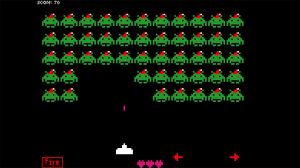


In [3]:
# !pip install tensorflow==2.5.0rc0 gym keras-rl2 gym[atari]

## Import Libraries ##

In [5]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

## Deep QNetwork

We are taking img height and width and passing it to a fully connected layer 32 * 32 * 6

In [7]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=6)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Experience class

In [8]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

## Replay Memory

In [9]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy ##

In [10]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

## Reinforcement Learning Agent ##

In [11]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions) #explore
            return torch.tensor([action]).to(device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) #exploit
        

## SpaceInvaders Environment Manager ##

In [12]:
class SpaceInvadersEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('SpaceInvaders-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            , T.Resize((40,90))
            , T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device)

## Outputs of Experience ##

In [13]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          moving_avg_period, "episode score avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension = 0, size = period, step = 1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    

## Tensor Processing ##

In [14]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1, t2, t3, t4)

## Q-Value Calculator ##

In [15]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Main Program and Answers ##

**1. Establish a baseline performance. How well did your Deep Q-learning do on your problem?**

total_episodes = 1000

learning_rate = 0.001

gamma = 0.999

epsilon = 1.0

max_epsilon = 1.0

min_epsilon = 0.01

decay_rate = 0.001


Our RL program with the SpaceInvaders-v0 gives us a score of 184.7 with this baseline performance, which is quite poor. The score at the beginning is almost same as score at the end, as shown by the graph.
It demonstrates that our real-world program does not learn how to play this game to win and get a higher score.

It could be that there are many options for each operation due to the high number of activities. Additionally, the e-greedy exploration technique is inadequate, necessitating the need for additional episodes to get higher learning outcomes.

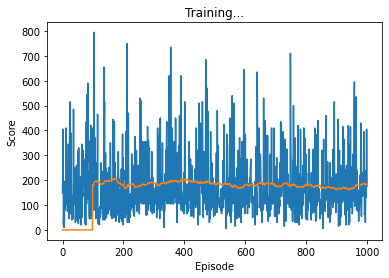

Episode 1000 
 100 episode score avg: 184.7


In [26]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**2. What are the states, the actions, and the size of the Q-table?**

The  image of the screen, which is an array of  (210, 160, 3). Every k frames, where k is evenly sampled from 2, 3, and 4, the environment receives each state.

["NOOP," "FIRE," "RIGHT," "LEFT," "RIGHTFIRE," "LEFTFIRE"] are the actions. This game has 6 different actions.

The Q-dimensions table's are: The equation: The total number of states times actions. Each state offers a variety of options, and the number of options equals the number of actions.

In [48]:
env_temp = gym.make('SpaceInvaders-v0')
print(env_temp.env.get_action_meanings())
print(env_temp.env.observation_space.shape)

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
(210, 160, 3)


**3. What are the rewards? Why did you choose them?**

Scores from the game are the rewards. Because improving your score is the ultimate objective of the game. The player's level of game play is expressed by the score. A higher score indicates a better grasp of the rules of the game. Additionally, the results are simple to count and compare, which is advantageous for the application of the educational process.

**4. How did you choose alpha and gamma in the Bellman equation? Try at least one additional value for alpha and gamma. How did it change the baseline performance?**

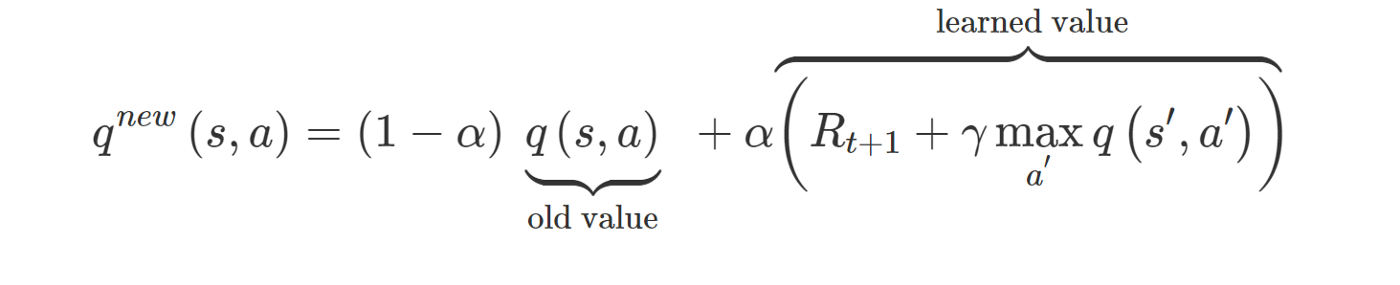



Changes in Q occur more quickly when learning rate (alpha) values are close to 1. The amount that recently learned knowledge covers previously learned information depends on the learning rate. When the factor is 0, the agent learns nothing (relying exclusively on prior knowledge), and when it is 1, the agent only takes into account information that has recently occurred (ignoring prior knowledge to explore possibilities). Alpha = 1 is the ideal learning rate in a perfectly specific environment. When the problem is random, the algorithm converges to a learning rate that necessitates, under specific technical circumstances, that it be decreased to zero.

The score is 184.7 when the alpha is 0.001. The score is 123.5 when the alpha is set to 0.999. It has been discovered that a higher alpha value causes scores to decline significantly. This demonstrates how the gaming environment is more prone to randomness. The more prior knowledge may be used to improve game score, the smaller the alpha.

Future rewards are weighted according to the discount factor gamma. A factor of 0 will make the agent focus just on the immediate benefit, which is shortsighted, but a factor close to 1 will encourage it to pursue high long-term returns. The operating value may diverge if the discount factor reaches or exceeds 1. In the case of gamma = 1, all environmental history will grow infinitely long if there is no terminal state or if the agent never reaches the terminal state, and the utility of additive, undiscounted rewards will typically become infinite.


The score is 184.7 when the gamma is 0.999. The result is 200.95 when the gamma factor is changed to 0.1. Additionally, it is evident that the score curve with low gamma value undergoes significant alteration. However, compared to the situation with high gamma value, the overall score is higher. This demonstrates that future awards shouldn't be given undue weight in this game. Increased utilization of existing prizes can result in higher scores more quickly.

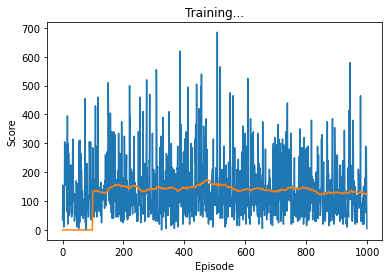

Episode 1000 
 100 episode score avg: 123.5


In [28]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.999
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

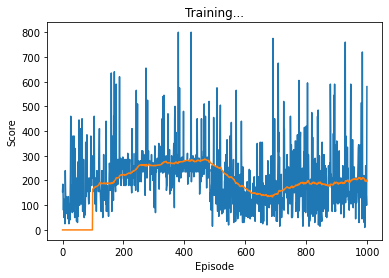

Episode 1000 
 100 episode score avg: 200.95


In [30]:
batch_size = 256
gamma = 0.1
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**5. Try a policy other than e-greedy. How did it change the baseline performance?**

I established a procedure for selecting actions based on random sampling.

Theoretically, the probability that the best conduct can be determined by random sampling decreases as the number of acts increases. Therefore, the random sample experiment's findings ought to be less favorable.

In reality, I discovered that the agent's game score is 144.15 after 1000 episodes by contrasting the same number of trials. This is less than the 184.7 of e-greedy. To put it another way, the baseline performance will suffer if the e-greedy strategy is replaced with a random sampling approach.

In [19]:
class RandomSamplingStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

In [20]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        self.current_step += 1

        action = random.randrange(self.num_actions) #explore
        return torch.tensor([action]).to(device)

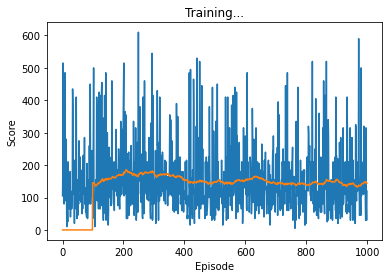

Episode 1000 
 100 episode score avg: 144.15


In [22]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = RandomSamplingStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**6. How did you choose your decay rate and starting epsilon? Try at least one additional value for epsilon and the decay rate. How did it change the baseline performance? What is the value of epsilon when if you reach the max steps per episode?**



I employ the 'epsilon greedy technique' to achieve this balance between development and exploration. An exploration rate is established. At first, we had it set to 1. The likelihood that our agent will investigate the environment rather than use it is represented by the exploration rate. And since e = 1, it is absolutely certain that the agent will begin by examining its surroundings.

At the start of every new episode, e will degrade at a pace we specify as the agent learns more about the environment, reducing the possibilities of exploration as the agent gains more environmental knowledge. The agent uses the environment in a "greedy" manner once given the chance to investigate and learn more about it.

We produce a random integer between 0 and 1 and use it to predict whether the agent will select exploitation or exploration at each time step. If this number is higher than epsilon, the agent will use exploitation to decide what to do next.

I chose 0.001 and 0.5 for the decay rates. When the decay rate is 0.5 after experiments, the score is 144.5. The score is 184.7 when the decay rate is 0.001. As a result, the likelihood of exploration will be swiftly diminished by an excessively high decay rate. The agent will continue to utilize an ineffective operating strategy. This does not help the agent receive better ratings.

I also chose 1 and 0.5 for the beginning epsilon. When beginning epsilon is 0.5 after experimentation, the result is 147.6. The score is 184.7 when beginning epsilon is 1. Therefore, a starting epsilon that is too small will prevent early exploration. Early on, the agent will make poor decisions, squandering a great deal of pointless tests. This does not help the agent receive a higher rating. I reach the maximum number of steps each episode when the decay rate is 0.001 and the starting epsilon is 1.

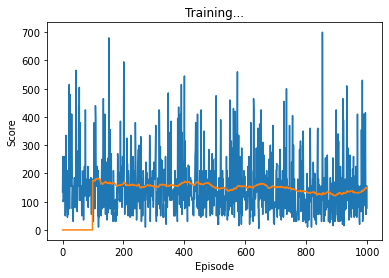

Episode 1000 
 100 episode score avg: 147.6


In [31]:
batch_size = 256
gamma = 0.999
eps_start = 0.5
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

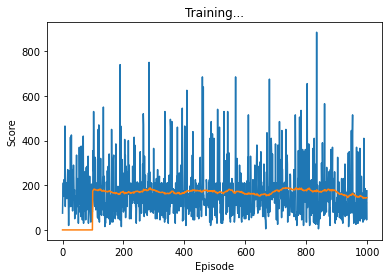

Episode 1000 
 100 episode score avg: 144.5


In [32]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.5
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            plot(episode_scores, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**7. What is the average number of steps taken per episode?**

The steps will be continuously carried out throughout each episode's loop until the contest is over. In order to create a chart, I logged the number of steps following the game's final step. According to the graph, an episode typically entails 618.84 steps.

In [16]:
def plot_steps(values, steps_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.plot(values)
    steps_avg = get_steps_average(steps_avg_period, values)
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
          steps_avg_period, "episode steps avg:", steps_avg[-1])
    if is_ipython: display.clear_output(wait=True)
        
def get_steps_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        steps_avg = values.unfold(dimension = 0, size = period, step = 1) \
            .mean(dim=1).flatten(start_dim=0)
        steps_avg = torch.cat((torch.zeros(period-1), steps_avg))
        return steps_avg.numpy()
    else:
        steps_avg = torch.zeros(len(values))
        return steps_avg.numpy()
    

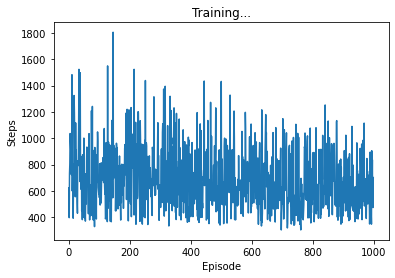

Episode 1000 
 100 episode steps avg: 618.84


In [17]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = SpaceInvadersEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_scores = []
steps = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    episode_scores.append(0)
    steps.append(0)
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        episode_scores[episode] += reward
        
        if(memory.can_provide_sample(batch_size)):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            steps[episode] = timestep
            plot_steps(steps, 100)
            break
    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

**8. Does Q-learning use value-based or policy-based iteration?**

Value-based iteration is used in Q-learning. In the value-based approach, a new value function is first discovered after a random value function has been chosen. Until the best value function is identified, this process is repeated. The best course of action is to adhere to the optimal value function. To determine the appropriate tactic in Q-learning, we update the Q value.

**9. Could you use SARSA for this problem?**

SARSA can help me resolve this issue. In contrast to q-learning, the Q value's strategy is utilized to choose actions from the state before each episode. Following the action's completion, the new state should be observed and a new action should be chosen using the approach. (I use e-greedy as a strategy in this game)

**10. What is meant by the expected lifetime value in the Bellman equation?**

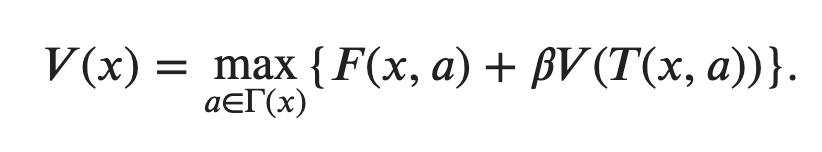

A set of functional equations about unknowable functions are known as the Bellman equations (objective functions). The functional equation approach refers to the process of using the embedding and optimization principles to create a system of functional equations. In practice, unique solutions should be sought in accordance with particular issues.

In this game, I use Bellman's equation and dynamic programming to optimize the agent's operational decisions. I set V as the expected lifetime value.

**11. When would SARSA likely do better than Q-learning?**

While Q-learning will disregard potential penalties from exploratory actions, SARSA will be quite near to convergence. SARSA now has a more conservative stance. While SARSA tends to avoid the perilous optimal road and only learn to utilize it slowly, Q-learning tends to activate the reward when investigating when there is a chance of a lot of negative rewards close to the optimal path.

In real life, we prefer to apply SARSA if the inaccuracy is expensive. This will help to minimize the high cost of inaccuracy throughout the exploration phase. And SARSA might be a preferable option if we are concerned with the benefits of the learning process.

**12. How does SARSA differ from Q-learning?**



The way Q is modified following each operation is the key distinction between the two.

Because A'is derived from Q', SARSA rigorously abides by the "-greedy" policy when using Q'.

In contrast, Q-learning selects the next action that has the highest Q'out of all feasible options. This gives the impression that it uses a greedy approach with =0, i.e., that there is no exploration in this section.

**13. Explain the Q-learning algorithm.**

Q-learning is a model-free reinforcement learning algorithm to learn the value of an action in a particular state. It does not require a model of the environment (hence "model-free"), and it can handle problems with stochastic transitions and rewards without requiring adaptations.

The formula and pseudocode as following:

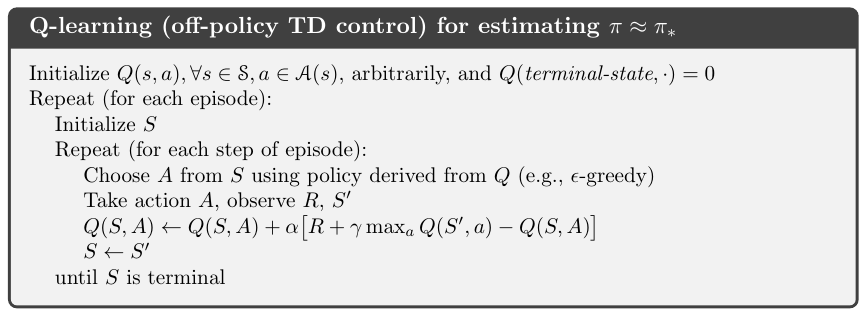

**14. Explain the SARSA algorithm.**

State Action Reward State Action (SARSA) is one of the algorithms of reinforcement learning which is a modified version of the Q-learning algorithm. The major point that differentiates the SARSA algorithm from the Q-learning algorithm is that it does not maximize the reward for the next stage of action to be performed and updates the Q-value for the corresponding states.

Among the two learning policies for the agent, SARSA uses the ON-policy learning technique where the agent learns from the current set of actions performed by the agents. There is no maximum operation that is being performed in the SARSA algorithm which makes it independent from the previous learning or greedy learning policy like the Q-learning algorithm.

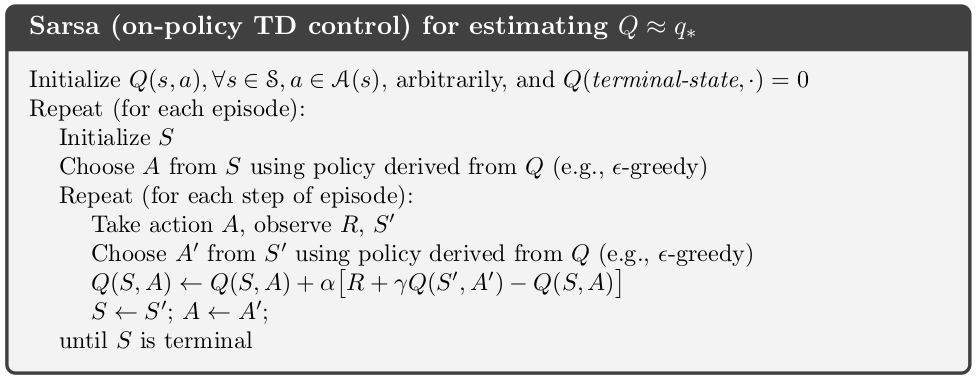

**15. What code is yours and what have you adapted?**

The code is from github and the i have changed hyperparameters and explained answers

https://github.com/nicknochnack/KerasRL-OpenAI-Atari-SpaceInvadersv0/blob/main/Space%20Invaders%20Walkthrough.ipynb
https://github.com/jasonbian97/Deep-Q-Learning-Atari-Pytorch/blob/master/utils.py
https://github.com/BoYanSTKO/Practical_RL-coursera/blob/master/week3_model_free/qlearning.py



**17. Did I explain my licensing clearly?**

Copyright 2022 Prasanth Dwadasi

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.